# Initiation

In [1]:
!pip install scikit-learn
!pip install keras
!pip install tqdm
!pip install opencv-python
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install torch
!pip install tensorflow

In [2]:
%pip install --upgrade tensorflow


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install distutils

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement distutils (from versions: none)
ERROR: No matching distribution found for distutils


In [4]:
!pip show tensorflow
!pip show keras


Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: C:\Users\wesla\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: tensorflow-intel
Required-by: 
Name: keras
Version: 3.2.1
Summary: Multi-backend Keras.
Home-page: https://github.com/keras-team/keras
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache License 2.0
Location: C:\Users\wesla\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, rich
Required-by: tensorflow-intel


In [5]:
pip install keras --upgrade


Note: you may need to restart the kernel to use updated packages.


In [23]:
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.models import load_model, Sequential, Model
from keras.layers import BatchNormalization, Conv2D, Dense, Activation, Flatten, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from tqdm import tqdm
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gc
import keras.backend as B
import random
import warnings


warnings.filterwarnings('ignore')


# 1-Exploration des données


## 1-2- Lecture des données

In [37]:
import os

In [38]:
# Chemin vers le fichier dataset.csv
chemin_dataset = "C:\\Users\\wesla\\Desktop\\pfe\\data\\dataset.csv"

# Charger le fichier dataset.csv dans un DataFrame
dataset = pd.read_csv(chemin_dataset)

# Chemin vers le dossier contenant les images
chemin_images = "C:\\Users\\wesla\\Desktop\\pfe\\files"

# Liste des noms de fichiers d'images
noms_images = os.listdir(chemin_images)

## 1-3- Affichage du nombre de données

In [9]:
print("Nombre de lignes dans le DataFrame original :", len(dataset))

Nombre de lignes dans le DataFrame original : 8932


In [39]:
# dictionary ship encoding 
ship = {'Cargo': 1, 
        'Military': 2, 
        'Carrier': 3, 
        'Cruise': 4, 
        'Tankers': 5}

In [40]:
print(dataset.head())

         image  category
0  2566698.jpg       4.0
1  2791673.jpg       2.0
2  2794927.jpg       4.0
3  2858013.jpg       5.0
4  2615152.jpg       4.0


In [11]:
print(dataset.category.unique)  #les valeurs de colonnes category

<bound method Series.unique of 0       4.0
1       2.0
2       4.0
3       5.0
4       4.0
       ... 
8927    1.0
8928    2.0
8929    5.0
8930    2.0
8931    NaN
Name: category, Length: 8932, dtype: float64>


## 1-4- Afficher d'un groupe d'images

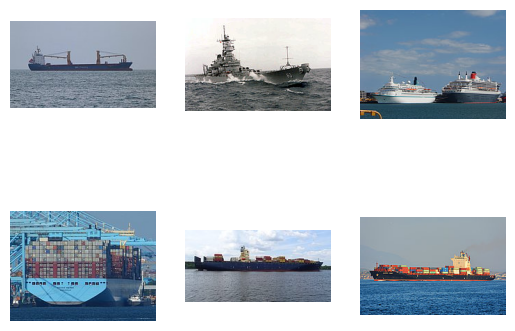

<Figure size 1200x2400 with 0 Axes>

In [42]:
# Nombre d'images à afficher
num_images_affiche = 6

# Sélection aléatoire de quelques images
selected_images = random.sample(noms_images, num_images_affiche)

# Création de la disposition du sous-tracé
fig, axs = plt.subplots(2, 3)
plt.figure(figsize=(12,24))
# Parcours des sous-tracés et affichage des images
for i, ax in enumerate(axs.flat):
    if i < len(selected_images):
        # Chemin complet de l'image
        image_path = os.path.join(chemin_images, selected_images[i])

        # Charger l'image
        image = plt.imread(image_path)

        # Afficher l'image
        
        ax.imshow(image)
        ax.axis('off')  # Désactiver les axes

# Ajustement de la disposition
plt.tight_layout()

# Affichage du tableau d'images
plt.show()


# 2- Preparation des données

## 2-1-Nombre de valeurs manquantes

In [43]:
print("\nNombre de valeurs manquantes :")
print(dataset.isnull().sum())


Nombre de valeurs manquantes :
image          0
category    2680
dtype: int64


## 2-2- Netoyage des données

In [44]:
# Chemin vers le fichier clean_data.csv (à créer)
chemin_clean_data = "C:\\Users\\wesla\\Desktop\\pfe\\data\\clean_data.csv"


# Filtrer les lignes où la colonne 'category' est différente de ' '
clean_dataset = dataset.dropna()

# Enregistrer les données filtrées dans un nouveau fichier clean_data.csv
clean_dataset.to_csv(chemin_clean_data, index=False)

# Supprimer les images du dossier data qui ont la catégorie ' '
images_a_supprimer = clean_dataset[clean_dataset['category'] == 'image']['image'].tolist()
for image in images_a_supprimer:
    chemin_image = os.path.join(chemin_images, image)
    if os.path.exists(chemin_image):
        os.remove(chemin_image)

print("Le fichier clean_data.csv a été créé avec succès dans :", chemin_clean_data)
print("Les images avec la catégorie ' ' ont été supprimées du dossier data.")

Le fichier clean_data.csv a été créé avec succès dans : C:\Users\wesla\Desktop\pfe\data\clean_data.csv
Les images avec la catégorie ' ' ont été supprimées du dossier data.


In [45]:
# Chemin vers le fichier clean_dataset.csv
clean_dataset = "C:\\Users\\wesla\\Desktop\\pfe\\data\\clean_data.csv"

# Charger le fichier dataset.csv dans un DataFrame
dataset = pd.read_csv(clean_dataset)

# Relecture des images apres nettoyage
chemin_images = "C:\\Users\\wesla\\Desktop\\pfe\\files"

# Liste des noms de fichiers des images netoyées
noms_images = os.listdir(chemin_images)

## 2-3-Répartition de la dataset en 3 parties:

In [46]:
chemin_destination = "C:\\Users\\wesla\\Desktop\\pfe\\data"
# Diviser les données en parties d'entraînement (80%) et de test (20%)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Diviser les données d'entraînement en parties d'entraînement (80%) et de validation (20%)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Créer un répertoire s'il n'existe pas
if not os.path.exists(chemin_destination):
    os.makedirs(chemin_destination)

# Sauvegarder les données divisées dans des fichiers CSV séparés
train_data.to_csv(os.path.join(chemin_destination, "train_data.csv"), index=False)
val_data.to_csv(os.path.join(chemin_destination, "val_data.csv"), index=False)
test_data.to_csv(os.path.join(chemin_destination, "test_data.csv"), index=False)

print("Les données ont été divisées avec succès et enregistrées dans", chemin_destination)

# Afficher la taille de chaque ensemble de données
print("Taille de l'ensemble de données d'entraînement :", len(train_data))
print("Taille de l'ensemble de données de validation :", len(val_data))
print("Taille de l'ensemble de données de test :", len(test_data))

print("Les données ont été divisées avec succès et enregistrées dans des fichiers CSV.")

Les données ont été divisées avec succès et enregistrées dans C:\Users\wesla\Desktop\pfe\data
Taille de l'ensemble de données d'entraînement : 4000
Taille de l'ensemble de données de validation : 1001
Taille de l'ensemble de données de test : 1251
Les données ont été divisées avec succès et enregistrées dans des fichiers CSV.


In [17]:
train_data['category'].value_counts(normalize=True)

category
1.0    0.34200
5.0    0.19425
2.0    0.18375
3.0    0.14175
4.0    0.13825
Name: proportion, dtype: float64

In [18]:
val_data['category'].value_counts(normalize=True)

category
1.0    0.323676
5.0    0.208791
2.0    0.191808
3.0    0.166833
4.0    0.108891
Name: proportion, dtype: float64

In [19]:
test_data['category'].value_counts(normalize=True)

category
1.0    0.342126
2.0    0.191847
5.0    0.184652
3.0    0.145484
4.0    0.135891
Name: proportion, dtype: float64

## Encode  Labels

In [47]:
file_train = train_data['image']
ohe = OneHotEncoder(dtype='int8')
y_train = ohe.fit_transform(train_data['category'].values.reshape(-1,1))

In [48]:
file_val = val_data['image']
ohe = OneHotEncoder(dtype='int8')
y_val = ohe.fit_transform(val_data['category'].values.reshape(-1,1))

In [49]:
file_test = test_data['image']
ohe = OneHotEncoder(dtype='int8')
y_test = ohe.fit_transform(test_data['category'].values.reshape(-1,1))

## 2-4- Analyse des caractéristiques

In [50]:
print("\nInformations sur les caractéristiques :")
print(dataset.info())


Informations sur les caractéristiques :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6252 entries, 0 to 6251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     6252 non-null   object 
 1   category  6252 non-null   float64
dtypes: float64(1), object(1)
memory usage: 97.8+ KB
None


In [51]:
print("Taille de la dataset :")
print(dataset.shape)

Taille de la dataset :
(6252, 2)


In [25]:
# Afficher les premières lignes du DataFrame
print("Aperçu des premières lignes du DataFrame :")
print(dataset.head())

Aperçu des premières lignes du DataFrame :
         image  category
0  2566698.jpg       4.0
1  2791673.jpg       2.0
2  2794927.jpg       4.0
3  2858013.jpg       5.0
4  2615152.jpg       4.0


In [26]:
# Statistiques descriptives
print("\nStatistiques descriptives :")
print(dataset.describe())


Statistiques descriptives :
          category
count  6252.000000
mean      2.657550
std       1.528998
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max       5.000000


<Axes: xlabel='category', ylabel='count'>

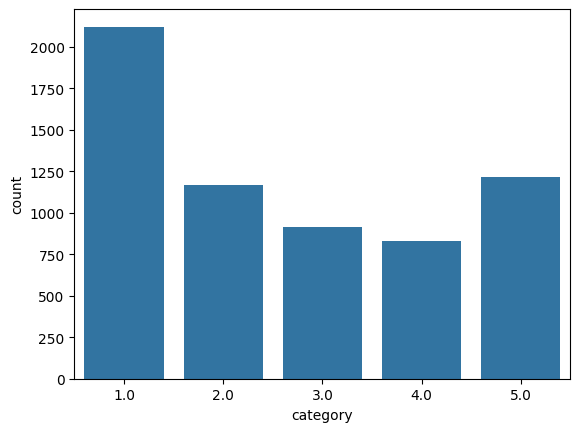

In [27]:
sns.countplot(x='category' , data=dataset)

In [28]:
print("Taille de la train_data :")
print(train_data.shape)

Taille de la train_data :
(4000, 2)


In [29]:
# Afficher les premières lignes du DataFrame
print("Aperçu des premières lignes du DataFrame :")
print(train_data.head())

Aperçu des premières lignes du DataFrame :
            image  category
1218  2816859.jpg       1.0
2742  2784301.jpg       1.0
750   2837626.jpg       1.0
2150  2888435.jpg       5.0
6234  2909481.jpg       3.0


In [30]:
# Statistiques descriptives
print("\nStatistiques descriptives :")
print(train_data.describe())


Statistiques descriptives :
          category
count  4000.000000
mean      2.659000
std       1.533397
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max       5.000000


<Axes: xlabel='category', ylabel='count'>

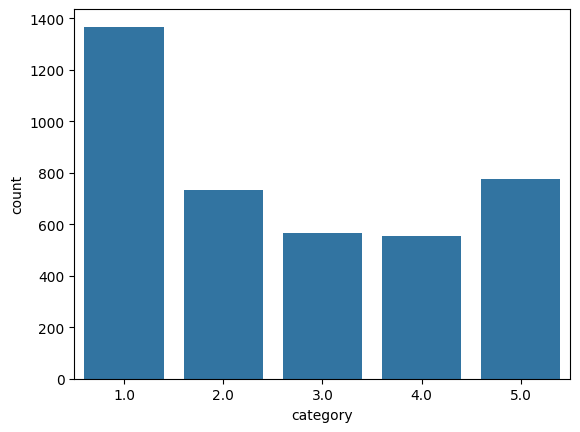

In [31]:
sns.countplot(x='category' , data=train_data)

In [32]:
print("Taille de la val_data :")
print(val_data.shape)

Taille de la val_data :
(1001, 2)


In [33]:
# Afficher les premières lignes du DataFrame
print("Aperçu des premières lignes du DataFrame :")
print(val_data.head())


Aperçu des premières lignes du DataFrame :
            image  category
3039  2900554.jpg       1.0
1748  2790353.jpg       1.0
2037  2788287.jpg       5.0
1988  2868131.jpg       5.0
2323  2841590.jpg       1.0


In [34]:
# Statistiques descriptives
print("\nStatistiques descriptives :")
print(val_data.describe())


Statistiques descriptives :
          category
count  1001.000000
mean      2.687313
std       1.528113
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max       5.000000


<Axes: xlabel='category', ylabel='count'>

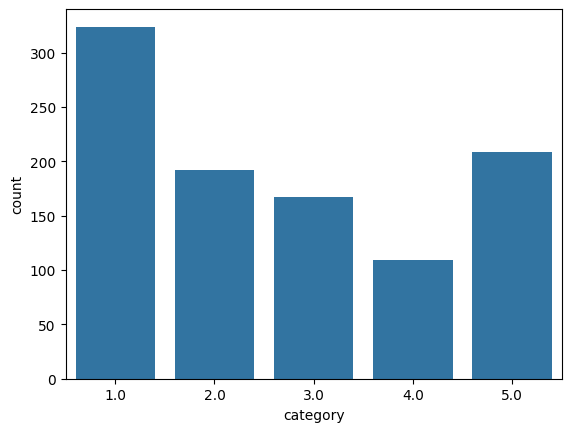

In [35]:
sns.countplot(x='category' , data=val_data)

In [36]:
print("Taille de la test_data :")
print(test_data.shape)

Taille de la test_data :
(1251, 2)


In [37]:
# Afficher les premières lignes du DataFrame
print("Aperçu des premières lignes du DataFrame :")
print(test_data.head())

Aperçu des premières lignes du DataFrame :
            image  category
1703  2825956.jpg       2.0
5448  2890389.jpg       5.0
5058  2845850.jpg       5.0
1149  2660628.jpg       4.0
432   2577807.jpg       2.0


In [38]:
# Statistiques descriptives
print("\nStatistiques descriptives :")
print(test_data.describe())


Statistiques descriptives :
          category
count  1251.000000
mean      2.629097
std       1.516285
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max       5.000000


<Axes: xlabel='category', ylabel='count'>

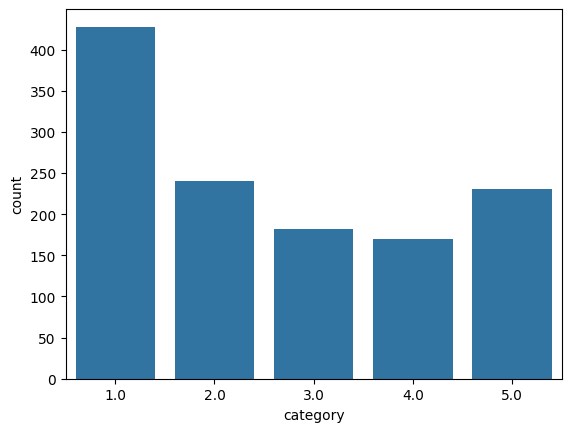

In [39]:
sns.countplot(x='category' , data=test_data)

## Load Train/Test Files

In [52]:
def load(what, target_size=(224,224)):
    array = []
    if what =='train':
        for file in tqdm(train_data['image'].values):
            img = load_img(os.path.join(chemin_images, file), target_size=target_size)
            img = img_to_array(img)/255. # normalize image tensor
            array.append(img)
    elif what =='val':
        for file in tqdm(val_data['image'].values):
            img = load_img(os.path.join(chemin_images, file), target_size=target_size)
            img = img_to_array(img)/255. # normalize image tensor
            array.append(img)
    elif what =='test':
        for file in tqdm(test_data['image'].values):
            img = load_img(os.path.join(chemin_images, file), target_size=target_size)
            img = img_to_array(img)/255. # normalize image tensor
            array.append(img)
    gc.collect()
    return np.asarray(array)

In [53]:
X_train = load('train')
X_val = load('val')
X_test = load('test')
print(f'train dtype: {X_train.dtype}')
print(f'val dtype: {X_val.dtype}')
print(f'test dtype: {X_test.dtype}')
print(f'train shape: {X_train.shape}')
print(f'val shape: {X_val.shape}')
print(f'test shape: {X_test.shape}')

100%|██████████| 1251/1251 [00:02<00:00, 600.51it/s]


train dtype: float32
val dtype: float32
test dtype: float32
train shape: (4000, 224, 224, 3)
val shape: (1001, 224, 224, 3)
test shape: (1251, 224, 224, 3)


# 3- Modelisation

## 3-1- Custom Callbacks for F1 Score
We need to create a custom callbacks function that calculates f1 score after every epoch to gauge model performance.

In [54]:
from keras import callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [55]:
class printf1(callbacks.Callback):           
    def __init__(self, X_train, y_train, X_val, y_val):
        super(printf1, self).__init__()
        self.bestf1 = 0
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs={}):
        pred = np.argmax(self.model.predict(np.array(self.X_train)), axis=1)
        f1 = f1_score(np.argmax(self.y_train, axis=1), pred, average='weighted')
        print("Train F1 Score: {:.4f}".format(f1))
        pred = np.argmax(self.model.predict(self.X_val), axis=1)
        f1 = f1_score(np.argmax(self.y_val, axis=1), pred, average='weighted')
        print("Valid F1 Score: {:.4f}".format(f1))
        return

In [56]:
# to plot training/validation history object
def plt_dynamic(x, vy, ty, ax, colors=['b'], title=''):
    ax.plot(x, vy, 'b', label='Validation Loss')
    ax.plot(x, ty, 'r', label='Train Loss')
    plt.legend()
    plt.grid()
    plt.title(title)
    fig.canvas.draw()
    plt.show()
    gc.collect()

In [57]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    gc.collect()

## 3-2-Load Pre-trained network and weights (Xception)
Utilize Keras pre-trained model and weights for faster and more accurate image classification models. Weights were loaded from training on Imagenet dataset.

In [58]:
from keras.applications.xception import Xception  
model = Xception(include_top=False, input_shape=(224,224,3), weights='imagenet')

In [59]:
from keras.layers import GlobalAveragePooling2D
x = GlobalAveragePooling2D()(model.output)

from keras.layers import Dense
output = Dense(5, activation='softmax')(x)

# define new model
model = Model(model.inputs, output)



## 3-3-Fine-tune Entire Pre-trained Xception Model

In [60]:
y_train = y_train.toarray()
y_val = y_val.toarray()
y_test = y_test.toarray()


In [61]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)
gc.collect()

(4000, 224, 224, 3)
(1001, 224, 224, 3)
(1251, 224, 224, 3)
(4000, 5)
(1001, 5)
(1251, 5)


714

In [62]:
batch_size = 8
epochs = 18
# make sure to keep learning rate low when fine-tuning


In [63]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer=Adam(learning_rate=0.0001))

In [64]:
datagen = ImageDataGenerator(rotation_range=45,
                             horizontal_flip=True,
                             width_shift_range=0.5,
                             height_shift_range=0.5,
                             dtype='float32')

In [ ]:
datagen.fit(X_train, augment=True, rounds=1, seed=2019)
train_generator = datagen.flow(X_train, y_train, 
                               batch_size=batch_size, 
                               seed=2019)

In [ ]:
f1 = printf1(X_train, y_train, X_val, y_val)
cp = ModelCheckpoint('best.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)     
annealer = LearningRateScheduler(lambda x: 1e-4 * 0.95 ** x)



history = model.fit(x=train_generator, 
                    steps_per_epoch=len(X_train) // batch_size, 
                    validation_data=[X_val, y_val], 
                    callbacks=[cp, f1, annealer],
                    epochs=epochs)



Epoch 1/18
125/125 ━━━━━━━━━━━━━━━━━━━━ 331s 3s/step
Train F1 Score: 0.9697
32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step
Valid F1 Score: 0.9339
500/500 ━━━━━━━━━━━━━━━━━━━━ 1921s 4s/step - accuracy: 0.9136 - loss: 0.2449 - val_accuracy: 0.9331 - val_loss: 0.1972 - learning_rate: 1.0000e-04
Epoch 2/18
125/125 ━━━━━━━━━━━━━━━━━━━━ 327s 3s/step
Train F1 Score: 0.9697
32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step
Valid F1 Score: 0.9339
500/500 ━━━━━━━━━━━━━━━━━━━━ 503s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9331 - val_loss: 0.1972 - learning_rate: 9.5000e-05
Epoch 3/18
125/125 ━━━━━━━━━━━━━━━━━━━━ 327s 3s/step
Train F1 Score: 0.9788
32/32 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step
Valid F1 Score: 0.9377
500/500 ━━━━━━━━━━━━━━━━━━━━ 1894s 4s/step - accuracy: 0.9158 - loss: 0.2342 - val_accuracy: 0.9381 - val_loss: 0.1964 - learning_rate: 9.0250e-05
Epoch 4/18
125/125 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step
Train F1 Score: 0.9788
32/32 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step
Valid F1 Score: 0.9377


In [ ]:
model.save('model.keras')

Evaluation

In [65]:
from keras.models import load_model

# Load the saved model
loaded_model = load_model('model.hdf5')
loaded_model.load_weights('best.weights.h5')




In [66]:
loaded_model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer=Adam(learning_rate=0.0001))

In [67]:
# Make predictions on the test data
pred = loaded_model.predict(X_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step


In [68]:
f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), average='weighted')
print("Test F1 Score: {:.4f}".format(f1))

Test F1 Score: 0.9498


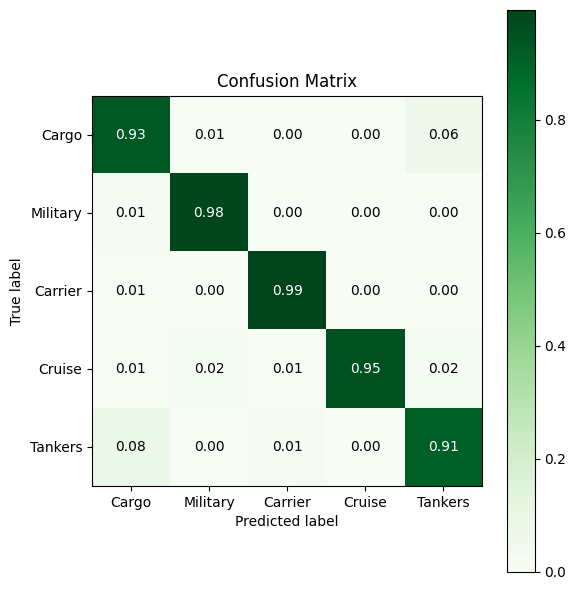

In [69]:
#plot confusion matrix
plot_confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), normalize=True, 
                      classes = ['Cargo','Military','Carrier','Cruise','Tankers'], title='Confusion Matrix')

In [90]:
import os
path = os.path.join("C:\\Users\\wesla\\Desktop", "hell.jpg")
images = []
target_size=(224,224)
img = load_img(path, target_size=target_size)
img = img_to_array(img)/255
images.append(img)
images = np.asarray(images)
predic = loaded_model.predict(images)
predic

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


array([[5.6168001e-02, 9.4380045e-01, 3.0558391e-07, 1.0808604e-06,
        3.0137891e-05]], dtype=float32)